# Data

> Create dataloader

In [ ]:
#| default_exp data

In [ ]:
#|export 
from fastcore.all import *
path = Path('../static')
path.mkdir(exist_ok=True)

In [ ]:
#| hide
from nbdev.showdoc import *

## Text Data Pipeline:

1. Downloaded Shakespeare text data, from [Karpathy's nanogpt](https://github.com/karpathy/build-nanogpt) 
1. Built a character-level Tokenizer (65 unique chars)
1. Created GPTDataset for non-overlapping sequence chunks
1. Made get_text_dl() function returning train/valid dataloaders with 90/10 split


In [ ]:
#|export 
urlsave("https://raw.githubusercontent.com/karpathy/build-nanogpt/refs/heads/master/input.txt", path) 

Path('../static/input.txt')

In [ ]:
#|export
from typing import List
class Tokenizer:
    """
    Maps each char to unique index. It have some key attributes i.e.
    1. **voacb**: where it maped to all the char present text field
    1. **encode**: to encode given string to list of tokens
    1. **decode**: to decode given tokens to str
    1. **c2i** and **i2c**: helper function to convert char to tokens and tokens to char respectively
    """
    def __init__(self):
        self.setup_vocab()

    def setup_vocab(self):
        with open(path/'input.txt', 'r') as file:
            self.txt = file.read()

        self.vocab = sorted(list(set(list(self.txt))))
        #print(f"After reading file got the vocab of shape : {len(self.vocab)}")

    def c2i(self, ch:str) -> int:
        """
        returns index of char ch from vocab
        """
        return self.vocab.index(ch)

    def i2c(self, idx:int) -> str:
        """
        returns char from vocab given index
        """
        return self.vocab[idx]

    def encode(self, inp:str) -> List[int]:
        """
        returns the encoded string
        """
        return [self.c2i(i) for i in inp]

    def decode(self, inp:List[int]) -> str:
        """
        returns the string represntation of the
        """
        return ''.join([self.i2c(i) for i in inp])

tokenizer = Tokenizer()

In [ ]:
s = 'abc'
assert tokenizer.decode(tokenizer.encode(s))  == s

The tokenizer is loss less.

### DataLoader
The Dataset should be of **non-overlapping chunks**:
1. `__init__` - store the encoded text and config (seq_len, etc.)
1. `__len__`: return `len(encoded_text) // seq_len - 1` (divide, not subtract)
1. `__getitem__`: use `idx * seq_len` as the starting position

In [ ]:
#|export
#|hide
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text, seq_len:int):
        self.text = text
        self.seq_len = seq_len
        self.encoded_text = tokenizer.encode(text)

    def __len__(self):
        return len(self.encoded_text) // self.seq_len -1

    def __getitem__(self, idx):
        inp = self.encoded_text[idx * self.seq_len : (idx + 1) * self.seq_len]
        op = self.encoded_text[idx * self.seq_len + 1 : (idx + 1) * self.seq_len + 1]
        return torch.tensor(inp), torch.tensor(op)

In [ ]:
#|export
def get_text_dl(bs:int=64, seq_len:int=128):
    split_idx = int(len(tokenizer.txt) * 0.9)                         #split text with 9:
    train_dataset = GPTDataset(tokenizer.txt[:split_idx], seq_len )
    val_dataset = GPTDataset(tokenizer.txt[split_idx:], seq_len)

    return {
        'train': DataLoader(train_dataset, batch_size=bs, shuffle=True),
        'valid': DataLoader(val_dataset, batch_size=bs, shuffle=False)
    }

In [ ]:
dl = get_text_dl()
for x, y in dl['train']:
    break
assert x.shape == y.shape

In [ ]:
x[0, :10], y[0,:10]

(tensor([52, 53, 59, 57, 50, 63, 11,  1, 40, 43]),
 tensor([53, 59, 57, 50, 63, 11,  1, 40, 43, 50]))

## Vision Fashion MNIST

**Steps:**

1. **Define transforms** - Convert images to tensors, normalize if needed

1. **Load Fashion MNIST dataset** - Use `torchvision.datasets.FashionMNIST()` for train and test splits

1. **Create DataLoaders** - Wrap datasets with DataLoader, set batch_size and shuffle=True for training

1. **Verify** - Check one batch to confirm shape (bs, 1, 28, 28) and labels (0-9)




In [ ]:
#| export
from torchvision import datasets, transforms
datasets.FashionMNIST(path, download=True)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../static
    Split: Train

In [ ]:
path.ls()

(#2) [Path('../static/input.txt'),Path('../static/FashionMNIST')]

In [ ]:
#|export 
import numpy as np
import matplotlib.pyplot as plt

def show_images(im, label=None, n=1, figsize=(2,2)):
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    if isinstance(im, torch.Tensor):
        if im.shape[0] == 1:
            im = im.squeeze(0)  # Remove channel dim for grayscale
        elif im.shape[0] == 3:
            im = im.permute(1, 2, 0)  # Change to (H, W, C)
        im = im.numpy()


    for i, ax in enumerate(axes):
        ax.imshow(im, cmap='gray')
        if label: ax.set_title(f"Label: {label}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
train_ds = datasets.FashionMNIST(path, train=True, transform=transforms.ToTensor())
valid_ds = datasets.FashionMNIST(path, transform=transforms.ToTensor())
im, lbl = train_ds[0]
type(im), lbl

(torch.Tensor, 9)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32)


In [ ]:
for x, y in train_dl:
    break


In [ ]:
len(valid_ds)

60000

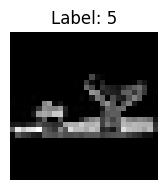

In [ ]:
show_images(*valid_ds[-1])

A helper function for retruning fashion mnist classification data

In [ ]:
#|export
def get_vision_classifier_dl(bs:int=64):
    im_path = path/'FashionMNIST'

    train_ds = datasets.FashionMNIST(im_path, train=True, transform=transforms.ToTensor())
    valid_ds = datasets.FashionMNIST(im_path, transform=transforms.ToTensor())

    return {
        'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
        'valid': DataLoader(valid_ds, batch_size=bs)
    }

In [ ]:
dl = get_vision_classifier_dl()
for x, y in dl['valid']:
    break
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

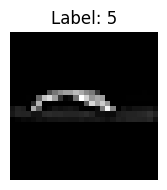

In [ ]:
show_images(x[-1], y[-1])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()